In [35]:
from triangle import triangulate
import quadpy
import numpy as np
import matplotlib.pyplot as plt
from testfunction import TestFunction
import torch

class GenData:
    def __init__(self, name:str='regualr', param:str='pq30a0.05eD') -> None:
        self.v = [[0, 0], [0, 1], [1, 1], [1, 0]]
        self.segments = [[0, 1], [1, 2], [2, 3], [3, 0]]
        self.t = triangulate({"vertices": self.v, 'segments': self.segments}, param)
        self.vertices = self.t['vertices']
        self.edges = self.t['edges']
        self.edges_markers  = self.t['edge_markers']
        self.triangles = self.t['triangles']
        self.triangles_coords = self.vertices[self.triangles]  # 形状为 [N,3,2], N为三角形个数
        self.Nv = self.vertices.shape[0]
        self.Nelt = self.triangles.shape[0]
        self.Nedge = self.edges.shape[0]
        # 获取边界边和内部边的序号
        boundary_edges_idx = np.where(self.edges_markers == 1)[0]  # 边界边的序号
        interior_edges_idx = np.where(self.edges_markers == 0)[0]  # 内部边的序号
        self.Niedge = interior_edges_idx.shape[0]
        self.Nbedge = boundary_edges_idx.shape[0]
        self.edge_vertices = self.vertices[self.edges]

        print(f'In the whole domain: ')
        print(f'{self.Nv} points')
        print(f'{self.Nelt} elements')
        print(f'{self.Nedge} faces/edges')
        print(f'{self.Niedge} interior edges, {self.Nbedge} boundary edges')

    def plot_mesh(self):
        plt.triplot(self.vertices[:,0], self.vertices[:,1], self.triangles) 
        plt.plot(self.vertices[:,0], self.vertices[:,1], 'o', markersize=1) 
        plt.axis('equal')
        plt.savefig('mesh.png') 
        plt.show()
    def get_elt_inf(self):
        p = self.triangles_coords.transpose(1, 0, 2)
        A = np.stack([p[1]-p[0], p[2]-p[0]], axis=1).transpose(0, 2, 1)
        b = p[0]
        area = np.linalg.det(A) / 2.
        elt_intp, elt_weights = self.get_elt_intp()
        return A, b, area, elt_intp, elt_weights
    
    def get_edge_inf(self):
        # 计算每条边的法向量和长度
        edge_vertices = self.edge_vertices  # shape: [Nedge, 2, 2]
        edge_vectors = edge_vertices[:,1,:] - edge_vertices[:,0,:]  # shape: [Nedge, 2]
        edge_lengths = np.sqrt(np.sum(edge_vectors**2, axis=1))  # shape: [Nedge]
        edge_normals = np.stack([-edge_vectors[:,1], edge_vectors[:,0]], axis=1)
        edge_normals = edge_normals / edge_lengths[:,None]  # 归一化
        edge_intp, edge_weights = self.get_edge_intp()
        return edge_normals, edge_lengths, edge_intp, edge_weights
    
    def get_elt_intp(self, degree: int=10):
        # 获取一个10阶的积分格式
        scheme = quadpy.t2.get_good_scheme(degree=degree)
        int_points_weights = scheme.points.transpose(1, 0)
        elt_weights = scheme.weights
        cord = self.triangles_coords[:, None, :, :]
        points_weights = int_points_weights[None, :, :, None]
        elt_intp = (cord * points_weights).sum(axis=2)
        return elt_intp, elt_weights

    def get_edge_intp(self, degree: int=10):
        # 使用quadpy生成线段上的积分格式
        scheme = quadpy.c1.gauss_legendre(10)
        points = scheme.points
        edge_weights = scheme.weights
        edge_vertices = self.edge_vertices  # shape: [Nedge, 2, 2]
        t = points[:, None]  # shape: [npoints, 1]
        edge_intp = ((1-t)/2 * edge_vertices[:,0:1,:] + (1+t)/2 * edge_vertices[:,1:2,:])  # shape: [Nedge, npoints, 2]      
        return edge_intp, edge_weights

    

GD = GenData(param='pq30a0.1eD')
# BE, be, area, intp, intpw = GD.get_elt_inf()
nvec, l, intp, intpw = GD.get_edge_inf()


In the whole domain: 
13 points
16 elements
28 faces/edges
20 interior edges, 8 boundary edges


In [20]:
v = [[0, 0], [0, 1], [1, 1], [1, 0]]
segments = [[0, 1], [1, 2], [2, 3], [3, 0]]
t = triangulate({"vertices": v, 'segments': segments}, 'pq30a0.1e')
vertices = t['vertices']
edges = t['edges']
edges_markers = t['edge_markers']
triangles = t['triangles']
triangles_coords = vertices[triangles]  # 形状为 [N,3,2], N为三角形个数
# 获取一个10阶的积分格式
scheme = quadpy.t2.get_good_scheme(10)
int_points_weights = scheme.points.transpose(1, 0)
int_weights = scheme.weights
Nv = vertices.shape[0]
Nelt = triangles.shape[0]
Nedge = edges.shape[0]
# 获取边界边和内部边的序号
boundary_edges_idx = np.where(edges_markers == 1)[0]  # 边界边的序号
interior_edges_idx = np.where(edges_markers == 0)[0]  # 内部边的序号
Niedge = interior_edges_idx.shape[0]
Nbedge = boundary_edges_idx.shape[0]
tce = triangles_coords[:, None, :, :]
ipwe = int_points_weights[None, :, :, None]
res = (ipwe * tce).sum(axis=2)

print(int_points_weights.shape)
print(f'In the whole domain: ')
print(f'{Nv} points')
print(f'{Nelt} elements')
print(f'{Nedge} faces/edges')
print(f'{Niedge} interior edges, {Nbedge} boundary edges')

(25, 3)
In the whole domain: 
13 points
16 elements
28 faces/edges
20 interior edges, 8 boundary edges


[-0.97390653 -0.86506337 -0.67940957 -0.43339539 -0.14887434  0.14887434
  0.43339539  0.67940957  0.86506337  0.97390653]


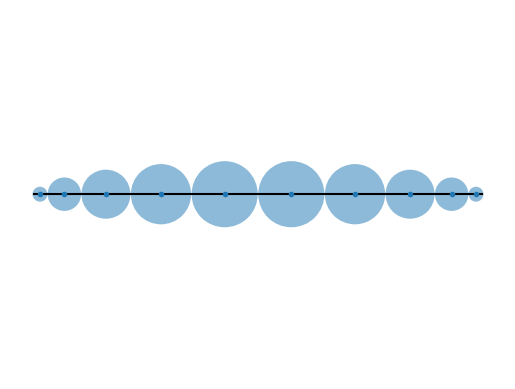

In [33]:
scheme = quadpy.c1.gauss_legendre(10)
print(scheme.points)
scheme.show()



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from triangle import triangulate
import math
from testfunction import TestFunction
import quadpy

class element:
    def __init__(self, vertex) -> None:
        self.face = np.zeros(3, dtype=int) # global number of faces
        self.reftype = -1 # -1 for inactive element and 0 for active element
        self.vertex = vertex # np.zeros(3, dtype=int)

class face:
    def __init__(self, vertex, neighbor) -> None:
        self.vertex = vertex # np.zeros(2, dtype=int) # global number of vertices
        self.neighbor = neighbor # np.zeros(2, dtype=int) # global number of vertices


class GenData:
    def __init__(self, name:str, param:str) -> None:
        # 初始化顶点、边和参数
        if name=='regular':
            self.v = [[0, 0], [0, 1], [1, 1], [1, 0]]
            self.segments = [[0, 1], [1, 2], [2, 3], [3, 0]]
        elif name=='irregular':
            self.v = [[0, 0], [1, 0], [1, 0.5], [0.5, 0.5], [0.5, 1], [0, 1]]
            self.segments = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
        else:
            return NotImplementedError
        self.para = param
        self.np_dtype = np.float64
        self.torch_dtype = torch.float32
        
        # 使用 triangulate 生成三角形网格
        t = triangulate({"vertices": self.v, 'segments': self.segments}, self.para)
        print('ok')
        self.Mesh = t["triangles"]
        # print(t['segments'])
        self.points = torch.tensor(t["vertices"], dtype=torch.float32)
        self.edges = t["edges"]
        # print(self.edges[0],self.Mesh[0])
        
        # 记录网格属性
        self.Nv = len(self.points)  # 顶点数量
        self.Nelt = len(self.Mesh)  # 元素数量
        self.Nedge = len(self.edges)  # 边数量
        self.Nif = 0  # 内部边数量
        self.Nbf = 0  # 边界边数量

        self.bdEdge = []
        self.inEdge = []

        # 遍历每条边，查找相邻的单元格 用于统计每条边的两边是哪两个单元，如果只有一个单元那代表是边界边
        for i, edge in enumerate(self.edges):
            neighbor = [k for k in range(self.Nelt) if edge[0] in self.Mesh[k] and edge[1] in self.Mesh[k]]
            # print(neighbor)
            
            if len(neighbor) == 2:  # 内部边
                e = face(edge, neighbor)
                self.inEdge.append(e)
                self.Nif += 1
            elif len(neighbor) == 1:  # 边界边
                e = face(edge, neighbor)
                self.bdEdge.append(e)
                self.Nbf += 1

        # 打印网格信息
        print(f'In the whole domain: ')
        print(f'{self.Nv} points')
        print(f'{self.Nelt} elements')
        print(f'{self.Nedge} faces/edges')
        print(f'{self.Nif} interior edges, {self.Nbf} boundary edges')


    
    def plot_mesh(self):
        '''
        plot the mesh
        '''
        print("Plot the mesh:")
        plt.triplot(self.points[:,0], self.points[:,1], self.Mesh) 
        plt.plot(self.points[:,0], self.points[:,1], 'o', markersize=1) 
        plt.axis('equal')
        plt.savefig('mesh.png') 
        plt.show()

    def test_function(self, mesh, deg):
        '''
        Calculate the values and derivatives of test functions
        
        Args:
            mesh: mesh object
            deg: degree of test functions
            
        Returns:
            v: values of test functions on each element, shape [Nelt, deg+1]
            dv: derivatives of test functions on each element, shape [Nelt, deg+1, 2]
        '''
        testfunc = TestFunction()
        v, dv = [], []
        for i in range(self.Nelt):
            elt = self.Mesh[i]
            p1 = self.points[elt[0]]; p2 = self.points[elt[1]]; p3 = self.points[elt[2]]; 
            BE, _ = self.computeBE(p1, p2, p3)
            invB = torch.inverse(BE)
            vi, dvi = [], []
            for k in range(deg + 1):
                vk, dvk = testfunc.get_value(mesh, k)
                dvk = torch.matmul(dvk, invB)
                # print(dvk.shape)
                vi.append(vk)
                dvi.append(dvk)
            v.append(vi)
            dv.append(dvi)
        return v, dv
            

    
    def Grids_elt(self, Nint_elt: int):
        '''
        给出每个单元上的积分点，步骤是先给出参考单元上的积分点，然后 通过仿射变换，之后变换到问题的网格单元上； 以及每个单元的面积
        output: 
            Grid: N_elt, N of int_elt, 2
            area: N_elt
        '''
        self.Grid = []
        self.Area = []
        p = self.get_grid_refelt(Nint_elt)
        for i in range(self.Nelt):
            elt = self.Mesh[i]
            p1 = self.points[elt[0]]; p2 = self.points[elt[1]]; p3 = self.points[elt[2]]; 
            BE, bE = self.computeBE(p1, p2, p3)
            area = torch.det(BE) / 2.
            P = torch.matmul(p, BE.T) + bE
            # print(p, BE, bE, P)
            self.Grid.append(P)
            self.Area.append(area)
        return torch.stack(self.Grid), torch.stack(self.Area)
    
    def Grids_edge(self, Nint_edge: int):
        '''
        由于需要做边界积分，给出从参考边上到实际边上的映射关系；最后给出的是每条边上的积分点坐标，每条边的法向量，每条边的长度
        return 
            Points:         Nelt * 3 * N of int_edge * 2, 
            Norm vector:    Nelt * 3 * 2
            length of edge: Nelt * 3
        '''
        self.Grid = []
        self.Nvec = []
        self.L = []
        for i in range(self.Nelt):
            elt = self.Mesh[i]
            p1 = self.points[elt[0]]; p2 = self.points[elt[1]]; p3 = self.points[elt[2]]; 
            grid, nvec, l = self.get_int_edge(p1, p2, p3, Nint_edge)
            self.Grid.append(grid)
            self.Nvec.append(nvec)
            self.L.append(l)
        return torch.stack(self.Grid), torch.stack(self.Nvec), torch.stack(self.L)      

    def Grids_bd_edge(self, N_bd):
        '''
        给出边界上的边上的积分点以及其唯一的相邻单元编号
        '''
        points = []
        neigh = []
        for i in range(self.Nbf):
            e = self.bdEdge[i]
            vertex = e.vertex
            n = e.neighbor[0]
            p1 = self.points[vertex[0]]; p2 = self.points[vertex[1]]; 
            t = torch.linspace(0, 1, N_bd)
            p = (1 - t).unsqueeze(-1) * p1 + t.unsqueeze(-1) * p2
            points.append(p)
            neigh.append(n)
        return torch.stack(points), neigh

    def Grids_inner_edge(self, N_test):
        '''
        给出区域内部边上的积分点以及其相邻单元编号，以及法向量
        '''
        points = []
        nvecs = []
        neigh = []
        for i in range(self.Nif):
            e = self.inEdge[i]
            vertex = e.vertex
            n = e.neighbor
            p1 = self.points[vertex[0]]; p2 = self.points[vertex[1]]; 
            vec = p2 - p1
            nvec = torch.tensor([vec[1], -vec[0]]); nvec = nvec / torch.norm(nvec)
            t = torch.linspace(0, 1, N_test)
            p = (1 - t).unsqueeze(-1) * p1 + t.unsqueeze(-1) * p2
            points.append(p)
            nvecs.append(nvec)
            neigh.append(n)
        return torch.stack(points), torch.stack(nvecs), neigh


    
    def computeBE(self, p1, p2, p3):
        '''
        用于计算参考单元到实际单元的仿射变换
        '''
        BE = torch.tensor([[p2[0]-p1[0], p3[0]-p1[0]], [p2[1]-p1[1], p3[1]-p1[1]]], dtype=torch.float32)
        bE = p1.clone()
        return BE, bE
    

    def get_grid_refelt(self, Nint_elt: int):
        '''g给出参考单元上的积分点'''
        x = np.linspace(0, 1, Nint_elt, dtype=self.np_dtype)
        y = np.linspace(0, 1, Nint_elt, dtype=self.np_dtype)
        X, Y = np.meshgrid(x, y)
        mask = 1 - X - Y > -1e-9
        points = np.column_stack((X[mask], Y[mask]))
        return torch.tensor(points, dtype=self.torch_dtype).view(-1, 2)
    
    

    
    def get_grid_refedge(self, Nint_edge):
        '''给出参考单元上边长上的积分点'''
        t = torch.linspace(0, 1, Nint_edge)
        edge1 = torch.stack([t, torch.zeros_like(t)], dim=1) 
        edge2 = torch.stack([1 - t, t], dim=1) 
        edge3 = torch.stack([torch.zeros_like(t), 1 - t], dim=1)
        edges = torch.stack([edge1, edge2, edge3], dim=0)
        return edges
    
    # 注：这里面的积分点其实都可以换成Gaussian积分点，但在这里为了简单，直接使用等分点, 
    # 在实际使用中，可以换成Gaussian积分点，这样精度会更高,但我没试过，你可以试一下，直接掉包就可以应该


    
    def get_int_edge(self, p1:torch.tensor, p2:torch.tensor, p3:torch.tensor, Nint_edge: int):
        '''
        给出每个单元上边长上的积分点，以及其法向量，以及每条边的长度
        '''
        t = torch.tensor(np.linspace(0, 1, Nint_edge), dtype=self.torch_dtype).view(-1, 1)
        vec1 = p2 - p1; vec2 = p3 - p2; vec3 = p1 - p3
        norm1 = torch.tensor([vec1[1], -vec1[0]]); norm1 = norm1 / torch.norm(norm1)
        norm2 = torch.tensor([vec2[1], -vec2[0]]); norm2 = norm2 / torch.norm(norm2)
        norm3 = torch.tensor([vec3[1], -vec3[0]]); norm3 = norm3 / torch.norm(norm3)
        l1 = torch.norm(vec1); l2 = torch.norm(vec2); l3 = torch.norm(vec3)
        points1 = t * vec1 + p1; points2 = t * vec2 + p2; points3 = t * vec3 + p3
        points = torch.stack([points1, points2, points3]) 
        norm_vecs = torch.stack([norm1, norm2, norm3])
        l = torch.stack([l1, l2, l3])
        return points, norm_vecs, l